# 0. Import Library

In [1]:
import os
if not os.path.exists("./tfdet"):
    !git clone -q http://github.com/burf/tfdetection.git
    !mv ./tfdetection/tfdet ./tfdet
    !rm -rf ./tfdetection

In [2]:
#ignore warning
import warnings, os
warnings.filterwarnings(action = "ignore")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

import tfdet

# 1. Balloon

1-1. Check Dataset

In [3]:
import os
path = "./balloon"
if not os.path.exists(path):
    !wget -qq --no-check-certificate http://github.com/matterport/Mask_RCNN/releases/download/v2.1/balloon_dataset.zip
    !unzip -qq balloon_dataset.zip
print(tfdet.dataset.util.tree_dir(path))

balloon/
    train/
        605521662_a470fef77f_b.jpg
        9330497995_4cf0438cb6_k.jpg
        5178670692_63a4365c9c_b.jpg
        ...
    val/
        4838031651_3e7b5ea5c7_b.jpg
        16335852991_f55de7958d_k.jpg
        24631331976_defa3bb61f_k.jpg
        ...


1-2. Load Dataset & Apply Transform

In [4]:
tr_path = os.path.join(path, "train/via_region_data.json")
te_path = os.path.join(path, "val/via_region_data.json")
label = tfdet.dataset.balloon.LABEL
color = None

image_shape = [512, 512]

tr_dataset = tfdet.dataset.balloon.load_dataset(tr_path, mask = True,
                                                cache = None)
tr_dataset = tfdet.dataset.Dataset(tr_dataset,
                                   transform = [{"name":"load"},
                                                {"name":"resize", "image_shape":image_shape},
                                                {"name":"pad", "image_shape":image_shape},
                                                {"name":"filter_annotation"},
                                                {"name":"label_encode", "label":label},
                                                {"name":"normalize", "mean":[123.675, 116.28, 103.53], "std":[58.395, 57.12, 57.375]}])

te_dataset = tfdet.dataset.balloon.load_dataset(te_path, mask = True,
                                                cache = None,
                                                transform = [{"name":"load"},
                                                             {"name":"resize", "image_shape":image_shape},
                                                             {"name":"pad", "image_shape":image_shape},
                                                             {"name":"filter_annotation"},
                                                             {"name":"label_encode", "label":label},
                                                             {"name":"normalize", "mean":[123.675, 116.28, 103.53], "std":[58.395, 57.12, 57.375]}])

print("train count:{0}, test count:{1}".format(len(tr_dataset), len(te_dataset)))

Preprocessing Data: 100%|███████████████████████| 13/13 [00:00<00:00, 26.09it/s]

train count:61, test count:13


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


x_true:(512, 512, 3), y_true:(1, 1), bbox_true:(1, 4), mask_true:(1, 512, 512, 1)


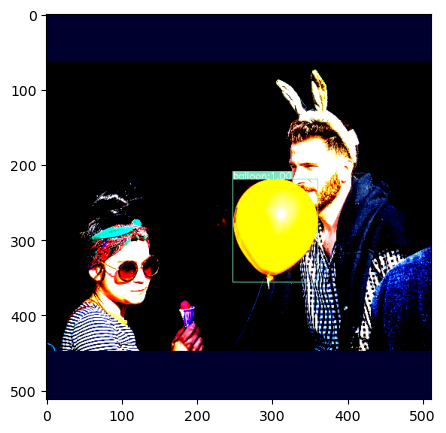

In [5]:
import matplotlib.pyplot as plt

out = tr_dataset[0] #or next(iter(tr_dataset))
x_true, y_true, bbox_true = out[:3]
mask_true = out[3] if 3 < len(out) else None

x_true = tfdet.util.draw_bbox(x_true, bbox_true, y_true = y_true, mask_true = mask_true, label = label, color = color)

if mask_true is None:
    print("x_true:{0}, y_true:{1}, bbox_true:{2}".format(x_true.shape, y_true.shape, bbox_true.shape))
else:
    print("x_true:{0}, y_true:{1}, bbox_true:{2}, mask_true:{3}".format(x_true.shape, y_true.shape, bbox_true.shape, mask_true.shape))

plt.figure(figsize = (5, 5))
plt.imshow(x_true)

1-3. Build Pipeline

In [6]:
tr_pipe = tfdet.dataset.PipeLoader(tr_dataset)
#tr_pipe = tfdet.dataset.pipeline.args2dict(tr_pipe) #for train_model
#tr_pipe = tfdet.dataset.pipeline.collect(tr_pipe) #filtered item by key
tr_pipe = tfdet.dataset.pipeline.key_map(tr_pipe, batch_size = 4, prefetch = True)

out = next(iter(tr_pipe))
image, y_true, bbox_true = out[:3]
mask_true = out[3] if 3 < len(out) else None

if mask_true is None:
    print("x_true:{0}, y_true:{1}, bbox_true:{2}".format(image.shape, y_true.shape, bbox_true.shape))
else:
    print("x_true:{0}, y_true:{1}, bbox_true:{2}, mask_true:{3}".format(image.shape, y_true.shape, bbox_true.shape, mask_true.shape))

x_true:(4, 512, 512, 3), y_true:(4, 10, 1), bbox_true:(4, 10, 4), mask_true:(4, 10, 512, 512, 1)


# 2. Pascal VOC

2-1. Check Dataset

In [7]:
import os
path = "./VOC2007"
if not os.path.exists(path):
    #http://host.robots.ox.ac.uk/pascal/VOC/voc2007
    #http://host.robots.ox.ac.uk/pascal/VOC/voc2012
    raise Exception("Please try again after modifying the path or downloading the dataset.")
print(tfdet.dataset.util.tree_dir(path))

VOC2007/
    ImageSets/
        Segmentation/
            train.txt
            trainval.txt
            val.txt
        Layout/
            train.txt
            trainval.txt
            val.txt
        Main/
            train_train.txt
            bus_train.txt
            bottle_train.txt
            ...
    SegmentationClass/
        007417.png
        009348.png
        004644.png
        ...
    SegmentationObject/
        007417.png
        009348.png
        004644.png
        ...
    Annotations/
        007826.xml
        002786.xml
        006286.xml
        ...
    JPEGImages/
        003301.jpg
        006279.jpg
        008254.jpg
        ...


2-2. Load Dataset & Apply Transform

In [8]:
tr_path = os.path.join(path, "ImageSets/Main/train.txt")
te_path = os.path.join(path, "ImageSets/Main/val.txt")

label = tfdet.dataset.pascal_voc.LABEL
color = tfdet.dataset.pascal_voc.COLOR

image_shape = [512, 512]

tr_dataset = tfdet.dataset.pascal_voc.load_dataset(tr_path, mask = True, truncated = True, difficult = False, 
                                                   cache = None)
tr_dataset = tfdet.dataset.Dataset(tr_dataset,
                                   transform = [{"name":"load"},
                                                {"name":"resize", "image_shape":image_shape},
                                                {"name":"pad", "image_shape":image_shape},
                                                {"name":"filter_annotation"},
                                                {"name":"label_encode", "label":label},
                                                {"name":"normalize", "mean":[123.675, 116.28, 103.53], "std":[58.395, 57.12, 57.375]}])

te_dataset = tfdet.dataset.pascal_voc.load_dataset(te_path, mask = True, truncated = True, difficult = False,
                                                   cache = None,
                                                   transform = [{"name":"load"},
                                                                {"name":"resize", "image_shape":image_shape},
                                                                {"name":"pad", "image_shape":image_shape},
                                                                {"name":"filter_annotation"},
                                                                {"name":"label_encode", "label":label},
                                                                {"name":"normalize", "mean":[123.675, 116.28, 103.53], "std":[58.395, 57.12, 57.375]}])

print("train count:{0}, test count:{1}".format(len(tr_dataset), len(te_dataset)))

Preprocessing Data: 100%|████████████████████| 213/213 [00:00<00:00, 762.09it/s]

train count:209, test count:213


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


x_true:(512, 512, 3), y_true:(4, 1), bbox_true:(4, 4), mask_true:(4, 512, 512, 1)


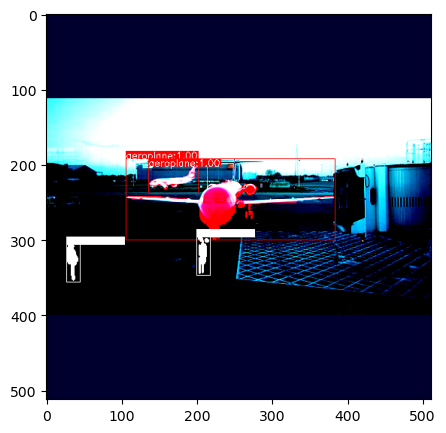

In [9]:
import matplotlib.pyplot as plt

out = tr_dataset[0] #or next(iter(tr_dataset))
x_true, y_true, bbox_true = out[:3]
mask_true = out[3] if 3 < len(out) else None

x_true = tfdet.util.draw_bbox(x_true, bbox_true, y_true = y_true, mask_true = mask_true, label = label, color = color)

if mask_true is None:
    print("x_true:{0}, y_true:{1}, bbox_true:{2}".format(x_true.shape, y_true.shape, bbox_true.shape))
else:
    print("x_true:{0}, y_true:{1}, bbox_true:{2}, mask_true:{3}".format(x_true.shape, y_true.shape, bbox_true.shape, mask_true.shape))

plt.figure(figsize = (5, 5))
plt.imshow(x_true)

2-3. Build Pipeline

In [10]:
tr_pipe = tfdet.dataset.PipeLoader(tr_dataset)
#tr_pipe = tfdet.dataset.pipeline.args2dict(tr_pipe) #for train_model
#tr_pipe = tfdet.dataset.pipeline.collect(tr_pipe) #filtered item by key
tr_pipe = tfdet.dataset.pipeline.key_map(tr_pipe, batch_size = 4, prefetch = True)

out = next(iter(tr_pipe))
image, y_true, bbox_true = out[:3]
mask_true = out[3] if 3 < len(out) else None

if mask_true is None:
    print("x_true:{0}, y_true:{1}, bbox_true:{2}".format(image.shape, y_true.shape, bbox_true.shape))
else:
    print("x_true:{0}, y_true:{1}, bbox_true:{2}, mask_true:{3}".format(image.shape, y_true.shape, bbox_true.shape, mask_true.shape))

x_true:(4, 512, 512, 3), y_true:(4, 4, 1), bbox_true:(4, 4, 4), mask_true:(4, 4, 512, 512, 1)


# 3. MS COCO

3-1. Check Dataset

In [11]:
import os
path = "./coco"
if not os.path.exists(path):
    #https://cocodataset.org
    raise Exception("Please try again after modifying the path or downloading the dataset.")
print(tfdet.dataset.util.tree_dir(path))

coco/
    val2017/
        000000182611.jpg
        000000335177.jpg
        000000278705.jpg
        ...
    test2017/
        000000339995.jpg
        000000088328.jpg
        000000426344.jpg
        ...
    annotations/
        person_keypoints_val2017.json
        captions_val2017.json
        stuff_val2017.json
        ...
        deprecated-challenge2017/
            val-ids.txt
            train-ids.txt
    train2017/
        000000109622.jpg
        000000160694.jpg
        000000308590.jpg
        ...


3-2. Load Dataset & Apply Transform

In [12]:
tr_path = os.path.join(path, "annotations/instances_train2017.json")
te_path = os.path.join(path, "annotations/instances_val2017.json")
tr_data_path = os.path.join(path, "train2017")
te_data_path = os.path.join(path, "val2017")

label = tfdet.dataset.coco.LABEL
color = tfdet.dataset.coco.COLOR

image_shape = [512, 512]

tr_dataset = tfdet.dataset.coco.load_dataset(tr_path, tr_data_path, mask = True, crowd = False, 
                                             cache = None)
tr_dataset = tfdet.dataset.Dataset(tr_dataset,
                                   transform = [{"name":"load"},
                                                {"name":"resize", "image_shape":image_shape},
                                                {"name":"pad", "image_shape":image_shape},
                                                {"name":"filter_annotation"},
                                                {"name":"label_encode", "label":label},
                                                {"name":"normalize", "mean":[123.675, 116.28, 103.53], "std":[58.395, 57.12, 57.375]}])

te_dataset = tfdet.dataset.coco.load_dataset(te_path, te_data_path, mask = True, crowd = False,
                                             cache = None,
                                             transform = [{"name":"load"},
                                                          {"name":"resize", "image_shape":image_shape},
                                                          {"name":"pad", "image_shape":image_shape},
                                                          {"name":"filter_annotation"},
                                                          {"name":"label_encode", "label":label},
                                                          {"name":"normalize", "mean":[123.675, 116.28, 103.53], "std":[58.395, 57.12, 57.375]}])

print("train count:{0}, test count:{1}".format(len(tr_dataset), len(te_dataset)))

loading annotations into memory...
Done (t=12.94s)
creating index...
index created!


Preprocessing Data: 100%|█████████████| 118287/118287 [00:50<00:00, 2327.01it/s]


loading annotations into memory...
Done (t=0.39s)
creating index...
index created!


Preprocessing Data: 100%|█████████████████| 5000/5000 [00:02<00:00, 2365.57it/s]

train count:118287, test count:5000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


x_true:(512, 512, 3), y_true:(4, 1), bbox_true:(4, 4), mask_true:(4, 512, 512, 1)


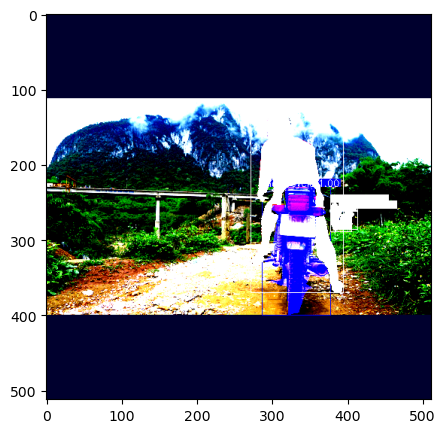

In [13]:
import matplotlib.pyplot as plt

out = tr_dataset[0] #or next(iter(tr_dataset))
x_true, y_true, bbox_true = out[:3]
mask_true = out[3] if 3 < len(out) else None

x_true = tfdet.util.draw_bbox(x_true, bbox_true, y_true = y_true, mask_true = mask_true, label = label, color = color)

if mask_true is None:
    print("x_true:{0}, y_true:{1}, bbox_true:{2}".format(x_true.shape, y_true.shape, bbox_true.shape))
else:
    print("x_true:{0}, y_true:{1}, bbox_true:{2}, mask_true:{3}".format(x_true.shape, y_true.shape, bbox_true.shape, mask_true.shape))

plt.figure(figsize = (5, 5))
plt.imshow(x_true)

3-3. Build Pipeline

In [14]:
tr_pipe = tfdet.dataset.PipeLoader(tr_dataset)
#tr_pipe = tfdet.dataset.pipeline.args2dict(tr_pipe) #for train_model
#tr_pipe = tfdet.dataset.pipeline.collect(tr_pipe) #filtered item by key
tr_pipe = tfdet.dataset.pipeline.key_map(tr_pipe, batch_size = 4, prefetch = True)

out = next(iter(tr_pipe))
image, y_true, bbox_true = out[:3]
mask_true = out[3] if 3 < len(out) else None

if mask_true is None:
    print("x_true:{0}, y_true:{1}, bbox_true:{2}".format(image.shape, y_true.shape, bbox_true.shape))
else:
    print("x_true:{0}, y_true:{1}, bbox_true:{2}, mask_true:{3}".format(image.shape, y_true.shape, bbox_true.shape, mask_true.shape))

x_true:(4, 512, 512, 3), y_true:(4, 23, 1), bbox_true:(4, 23, 4), mask_true:(4, 23, 512, 512, 1)
